# Modelado de T√≥picos con BERTopic

Este notebook implementa un an√°lisis de t√≥picos usando BERTopic sobre las opiniones tur√≠sticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres sem√°nticamente coherentes a los t√≥picos identificados.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import os
import sys
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

# Agregar la carpeta scripts al path para importar m√≥dulos
sys.path.append('../scripts')

# Importar m√≥dulo de limpieza de texto
from topicos import LimpiadorTextoMejorado, generar_reporte_limpieza, mostrar_ejemplos_limpieza

load_dotenv()
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [18]:
class TopicNaming(BaseModel):
    nombre_topico: str = Field(description="Nombre descriptivo del t√≥pico en espa√±ol")

def configurar_clasificador_topicos():
    llm = ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0,
        max_tokens=50
    )
    
    parser = PydanticOutputParser(pydantic_object=TopicNaming)
    
    prompt_template = """Eres un experto en an√°lisis de opiniones tur√≠sticas y modelado de t√≥picos.

Analiza las siguientes palabras clave que representan un t√≥pico identificado autom√°ticamente en rese√±as de atracciones tur√≠sticas en M√©xico (Canc√∫n, CDMX, Mazatl√°n, Puebla, Puerto Vallarta).

Palabras clave del t√≥pico: {keywords}

Bas√°ndote en estas palabras, asigna un nombre descriptivo y coherente al t√≥pico que capture la esencia de las opiniones tur√≠sticas que representa. El nombre debe ser:
- Espec√≠fico y relacionado con turismo
- En espa√±ol
- M√°ximo 4 palabras
- Descriptivo de la experiencia o aspecto tur√≠stico
- Evitar mencionar entidades espec√≠ficas (nombres de lugares, marcas, personas)

{format_instructions}
"""
    
    prompt = PromptTemplate(
        template=prompt_template,
        input_variables=["keywords"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    return prompt | llm | parser

clasificador_topicos = configurar_clasificador_topicos()

In [19]:
# Configurar ciudad a analizar
CIUDAD_ANALIZAR = "Cdmx"  # Cambiar por la ciudad deseada: Cancun, Cdmx, Mazatlan, Puebla, Puerto_Vallarta

df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

# Inicializar columna TopicoConBERTopic si no existe
if 'TopicoConBERTopic' not in df.columns:
    df['TopicoConBERTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Columnas disponibles: {list(df.columns)}")
print(f"\nDistribuci√≥n total por ciudad:")
print(df['Ciudad'].value_counts())

# Filtrar por ciudad espec√≠fica
df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()
print(f"\nüéØ Analizando ciudad: {CIUDAD_ANALIZAR}")
print(f"Opiniones de {CIUDAD_ANALIZAR}: {len(df_ciudad)}")

# Siempre usar texto limpio para BERTopic si est√° disponible
if 'TituloReviewLimpio' in df_ciudad.columns:
    columna_texto = 'TituloReviewLimpio'
    print(f"üìù Usando texto limpio para an√°lisis de t√≥picos")
else:
    columna_texto = 'TituloReview'
    print(f"‚ö†Ô∏è Usando texto original (sin limpiar)")

texts = df_ciudad[columna_texto].dropna().tolist()

print(f"üìù Columna de texto utilizada: {columna_texto}")
print(f"üßπ Textos para an√°lisis: {len(texts)} opiniones")

# Mostrar estad√≠sticas de texto
if len(texts) > 0:
    palabras_promedio = sum(len(text.split()) for text in texts) / len(texts)
    print(f"üìä Promedio de palabras por texto: {palabras_promedio:.1f}")
    print(f"üìè Longitud promedio: {sum(len(text) for text in texts) / len(texts):.1f} caracteres")

Dataset cargado: 2464 opiniones
Columnas disponibles: ['Titulo', 'Review', 'Calificacion', 'FechaEstadia', 'Ciudad', 'Atraccion', 'TituloReview', 'TituloReviewLimpio', 'SentimientoPorCalificacion', 'SentimientoPorHF', 'SentimientoPorCardiff', 'SubjetividadConHF', 'SubjetividadConFrases', 'SubjetividadConLLM', 'TopicoConBERTopic']

Distribuci√≥n total por ciudad:
Ciudad
Puebla             500
Mazatlan           500
Puerto_vallarta    491
Cdmx               490
Cancun             483
Name: count, dtype: int64

üéØ Analizando ciudad: Cdmx
Opiniones de Cdmx: 490
üìù Usando texto limpio para an√°lisis de t√≥picos
üìù Columna de texto utilizada: TituloReviewLimpio
üßπ Textos para an√°lisis: 490 opiniones
üìä Promedio de palabras por texto: 31.4
üìè Longitud promedio: 235.7 caracteres


In [20]:
# ===== LIMPIEZA DE TEXTO PARA AN√ÅLISIS DE T√ìPICOS =====


print("üßπ Iniciando proceso de limpieza de texto...")

# Crear instancia del limpiador
limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])

# Guardar DataFrame antes de la limpieza para comparaci√≥n
df_antes = df.copy()

# Aplicar limpieza al dataset completo
df = limpiador.limpiar_dataframe(
    df, 
    columna_texto='TituloReview',
    nombre_columna_limpia='TituloReviewLimpio',
    aplicar_lematizacion=True,
    min_longitud_palabra=2,
    max_palabras=None
)

# Mostrar ejemplos de limpieza
print(f"\nüîç Ejemplos de limpieza aplicada:")
mostrar_ejemplos_limpieza(df, n_ejemplos=3)

# Generar reporte completo
generar_reporte_limpieza(df_antes, df, 'TituloReview', 'TituloReviewLimpio')

# Guardar dataset actualizado
df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)
print(f"\nüíæ Dataset actualizado y guardado con columna 'TituloReviewLimpio'")


print(f"\nüìã Estructura actual del dataset:")
print(f"Dimensiones: {df.shape}")
print(f"Columnas: {list(df.columns)}")

# Mostrar posici√≥n de las columnas de texto
pos_original = df.columns.get_loc('TituloReview') + 1
pos_limpia = df.columns.get_loc('TituloReviewLimpio') + 1
print(f"üìç TituloReview: columna {pos_original}")
print(f"üìç TituloReviewLimpio: columna {pos_limpia}")

üßπ Iniciando proceso de limpieza de texto...
Limpiando columna 'TituloReview'...
Procesando 2464 textos...
Procesado: 0/2464 textos
Procesado: 1000/2464 textos
Procesado: 1000/2464 textos
Procesado: 2000/2464 textos
Procesado: 2000/2464 textos
‚úì Columna 'TituloReviewLimpio' actualizada

üìä Estad√≠sticas de limpieza:
   ‚Ä¢ Textos procesados: 2464
   ‚Ä¢ Textos v√°lidos: 2464
   ‚Ä¢ Textos vac√≠os: 0
   ‚Ä¢ Promedio palabras original: 57.2
   ‚Ä¢ Promedio palabras limpio: 30.4
   ‚Ä¢ Reducci√≥n promedio: 46.9%

üîç Ejemplos de limpieza aplicada:

üîç EJEMPLOS DE LIMPIEZA DE TEXTO (mostrando 3)

üìÑ EJEMPLO 1:
üî∏ Original: Muy buena atenci√≥n. Excelente trato!!! Me llev√© una grata sorpresa, yo ten√≠a boletos para otra compa√±√≠a y nos dieron mal el horario y perdimos  el √∫ltimo ferry de esa compa√±√≠a y el trabajador de nombre Emmanuel Alejandro aunque no ten√≠a boletos de su compa√±√≠a me orient√≥ de la mejor forma y me explico c√≥mo llegar a mi destino y termin√© comprando

In [21]:
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

vectorizer_model = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words=None,
    min_df=2,
    max_features=1000
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True
)

print("Entrenando modelo BERTopic...")
topics, probs = topic_model.fit_transform(texts)

2025-09-11 17:43:58,418 - BERTopic - Embedding - Transforming documents to embeddings.


Entrenando modelo BERTopic...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2025-09-11 17:44:19,202 - BERTopic - Embedding - Completed ‚úì
2025-09-11 17:44:19,208 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-11 17:44:19,208 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-11 17:44:20,750 - BERTopic - Dimensionality - Completed ‚úì
2025-09-11 17:44:20,750 - BERTopic - Dimensionality - Completed ‚úì
2025-09-11 17:44:20,753 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-11 17:44:20,753 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-11 17:44:20,824 - BERTopic - Cluster - Completed ‚úì
2025-09-11 17:44:20,832 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-11 17:44:20,824 - BERTopic - Cluster - Completed ‚úì
2025-09-11 17:44:20,832 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-11 17:44:20,993 - BERTopic - Representation - Completed ‚úì
2025-09-11 17:44:20,993 - BERTo

In [22]:
topic_info = topic_model.get_topic_info()
print(f"T√≥picos identificados: {len(topic_info)} (incluyendo outliers)")

topic_names = {}
for topic_id in topic_info['Topic']:
    if topic_id == -1:
        topic_names[topic_id] = "Opiniones Diversas"
        continue
    
    topic_words = topic_model.get_topic(topic_id)
    keywords = ", ".join([word for word, _ in topic_words[:8]])
    
    resultado = clasificador_topicos.invoke({"keywords": keywords})
    topic_names[topic_id] = resultado.nombre_topico
    
    print(f"T√≥pico {topic_id}: {topic_names[topic_id]}")
    print(f"  Palabras clave: {keywords}")
    print()

topic_model.set_topic_labels(topic_names)

T√≥picos identificados: 11 (incluyendo outliers)
T√≥pico 0: Experiencias en museos
  Palabras clave: museo, arte, museum, visitar, historia, mas, frida, art

T√≥pico 0: Experiencias en museos
  Palabras clave: museo, arte, museum, visitar, historia, mas, frida, art

T√≥pico 1: Cultura y Arte Mexicano
  Palabras clave: museum, mexico, museo, arte, city, history, mexican, mexico city

T√≥pico 1: Cultura y Arte Mexicano
  Palabras clave: museum, mexico, museo, arte, city, history, mexican, mexico city

T√≥pico 2: Experiencia religiosa y cultural
  Palabras clave: basilica, guadalupe, time, virgen, lugar, visit, tour, beautiful

T√≥pico 2: Experiencia religiosa y cultural
  Palabras clave: basilica, guadalupe, time, virgen, lugar, visit, tour, beautiful

T√≥pico 3: Visitas a Z√≥calos Urbanos
  Palabras clave: ciudad, plaza, ciudad mexico, mexico, zocalo, visita, visita obligada, obligada

T√≥pico 3: Visitas a Z√≥calos Urbanos
  Palabras clave: ciudad, plaza, ciudad mexico, mexico, zocalo, 

In [ ]:
# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topics
df_con_topicos['Topico_Nombre'] = df_con_topicos['Topico'].map(topic_names)
df_con_topicos['Probabilidad_Topico'] = probs.max(axis=1)

# Verificar si la ciudad ya ten√≠a resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConBERTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"üîÑ SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   üìù Opiniones con t√≥picos previos: {opiniones_previas}")
    print(f"   üÜï Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")
else:
    print(f"üÜï PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   üìù Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")

# Actualizar el dataset original con los t√≥picos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConBERTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n‚úÖ Actualizaci√≥n completada para {CIUDAD_ANALIZAR}")
print(f"Distribuci√≥n de t√≥picos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por t√≥pico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualizaci√≥n dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con t√≥pico asignado: {df['TopicoConBERTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConBERTopic'].isna().sum()}")

# Mostrar calidad de la limpieza aplicada
if columna_texto == 'TituloReviewLimpio':
    textos_vacios = df_con_topicos[columna_texto].str.strip().eq('').sum()
    print(f"\nüßπ Calidad de limpieza en {CIUDAD_ANALIZAR}:")
    print(f"Textos vac√≠os tras limpieza: {textos_vacios}")
    print(f"Textos v√°lidos para an√°lisis: {len(df_con_topicos) - textos_vacios}")
    
    # Comparar longitud promedio original vs limpia
    if 'TituloReview' in df_con_topicos.columns:
        len_original = df_con_topicos['TituloReview'].str.len().mean()
        len_limpia = df_con_topicos['TituloReviewLimpio'].str.len().mean()
        reduccion = ((len_original - len_limpia) / len_original * 100)
        print(f"Reducci√≥n promedio de texto: {reduccion:.1f}%")

Distribuci√≥n de t√≥picos en Cdmx:
Topico_Nombre
Experiencias en museos                 102
Cultura y Arte Mexicano                 80
Opiniones Diversas                      79
Experiencia religiosa y cultural        42
Visitas a Z√≥calos Urbanos               37
Experiencias en Mercados Locales        36
Cultura y Artes Urbanas                 33
Experiencia en Acuarios Limpios         27
Experiencia en parques hist√≥ricos       24
Experiencia en Atracciones Grupales     19
Visitas a museos                        11
Name: count, dtype: int64

Porcentaje de opiniones por t√≥pico en Cdmx:
Experiencias en museos: 20.82%
Cultura y Arte Mexicano: 16.33%
Opiniones Diversas: 16.12%
Experiencia religiosa y cultural: 8.57%
Visitas a Z√≥calos Urbanos: 7.55%
Experiencias en Mercados Locales: 7.35%
Cultura y Artes Urbanas: 6.73%
Experiencia en Acuarios Limpios: 5.51%
Experiencia en parques hist√≥ricos: 4.9%
Experiencia en Atracciones Grupales: 3.88%
Visitas a museos: 2.24%

Estado actualizaci√≥n

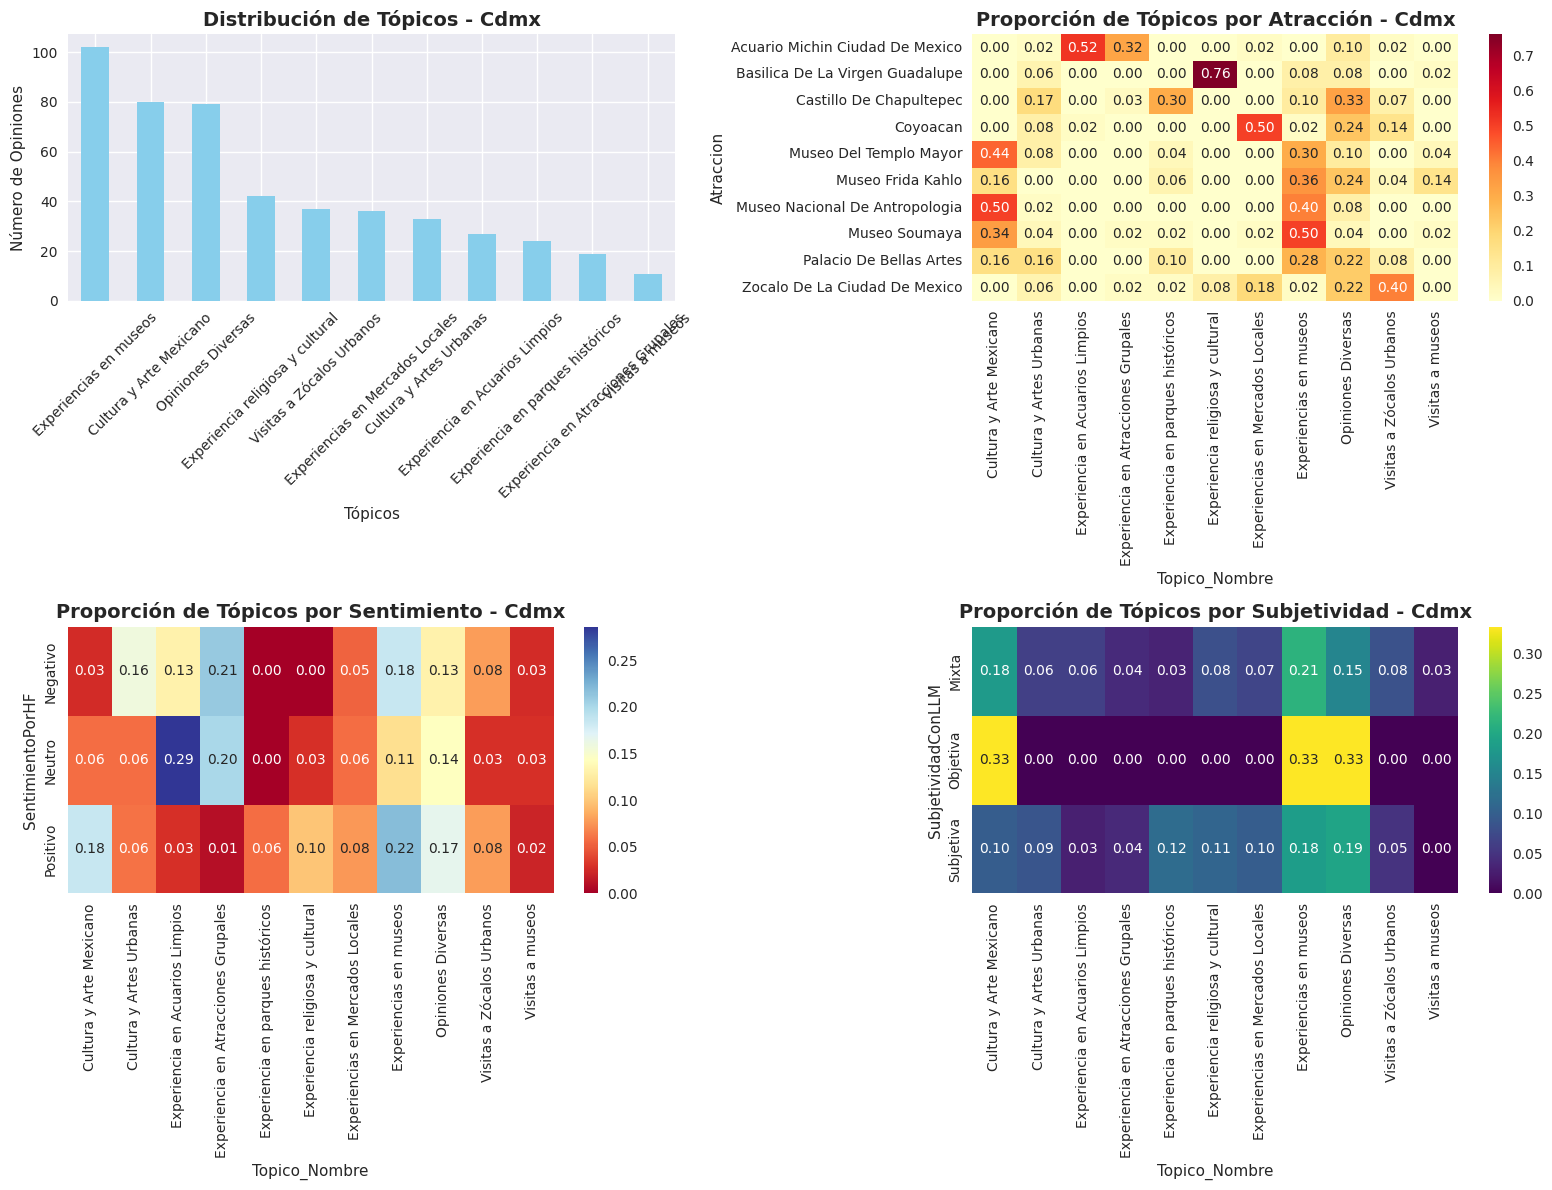

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gr√°fico 1: Distribuci√≥n de t√≥picos en la ciudad
topico_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title(f'Distribuci√≥n de T√≥picos - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('T√≥picos')
axes[0,0].set_ylabel('N√∫mero de Opiniones')
axes[0,0].tick_params(axis='x', rotation=45)

# Gr√°fico 2: Distribuci√≥n por atracci√≥n en la ciudad
if len(df_con_topicos['Atraccion'].unique()) > 1:
    atraccion_topico = pd.crosstab(df_con_topicos['Atraccion'], df_con_topicos['Topico_Nombre'])
    atraccion_topico_norm = atraccion_topico.div(atraccion_topico.sum(axis=1), axis=0)
    sns.heatmap(atraccion_topico_norm, annot=True, fmt='.2f', ax=axes[0,1], cmap='YlOrRd')
    axes[0,1].set_title(f'Proporci√≥n de T√≥picos por Atracci√≥n - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
else:
    axes[0,1].text(0.5, 0.5, f'Solo una atracci√≥n en {CIUDAD_ANALIZAR}', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title(f'Distribuci√≥n por Atracci√≥n - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gr√°fico 3: T√≥picos por sentimiento
sentimiento_topico = pd.crosstab(df_con_topicos['SentimientoPorHF'], df_con_topicos['Topico_Nombre'])
sentimiento_topico_norm = sentimiento_topico.div(sentimiento_topico.sum(axis=1), axis=0)
sns.heatmap(sentimiento_topico_norm, annot=True, fmt='.2f', ax=axes[1,0], cmap='RdYlBu')
axes[1,0].set_title(f'Proporci√≥n de T√≥picos por Sentimiento - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gr√°fico 4: T√≥picos por subjetividad
subjetividad_topico = pd.crosstab(df_con_topicos['SubjetividadConLLM'], df_con_topicos['Topico_Nombre'])
subjetividad_topico_norm = subjetividad_topico.div(subjetividad_topico.sum(axis=1), axis=0)
sns.heatmap(subjetividad_topico_norm, annot=True, fmt='.2f', ax=axes[1,1], cmap='viridis')
axes[1,1].set_title(f'Proporci√≥n de T√≥picos por Subjetividad - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
print(f"Ejemplos de opiniones por t√≥pico en {CIUDAD_ANALIZAR}:")
print("=" * 60)

for topico_nombre in topico_counts.index[:5]:
    ejemplos = df_con_topicos[df_con_topicos['Topico_Nombre'] == topico_nombre]['TituloReview'].head(3)
    print(f"\nüè∑Ô∏è T√≥pico: {topico_nombre}")
    print(f"üìä Total de opiniones: {topico_counts[topico_nombre]}")
    print("üìù Ejemplos:")
    for i, ejemplo in enumerate(ejemplos, 1):
        print(f"  {i}. {ejemplo[:100]}{'...' if len(ejemplo) > 100 else ''}")
    print("-" * 50)

Ejemplos de opiniones por t√≥pico en Cdmx:

üè∑Ô∏è T√≥pico: Experiencias en museos
üìä Total de opiniones: 102
üìù Ejemplos:
  1. Vale la pena. Vale la pena, lleno de historia y de cosas tan bellas vale la pena tomarse el tiempo d...
  2. Views and Murals. From the archeological museum we walked around the lake and up to the castle. At t...
  3. Un lugar que se debe visitar. La visita es muy interesante, en la ma√±ana la entrada s√∫per tranquila ...
--------------------------------------------------

üè∑Ô∏è T√≥pico: Cultura y Arte Mexicano
üìä Total de opiniones: 80
üìù Ejemplos:
  1. A journey to the centre of the Aztec People. Wonderful experience to understand the culture and soci...
  2. Remarkable viewable open air ruins. Remarkable open air ruins viewable from the street. Museum attac...
  3. Can view some of it from outside. On the first day we landed in Mexico City, we did a walking tour a...
--------------------------------------------------

üè∑Ô∏è T√≥pico: Opiniones D

üîç Comparaci√≥n de ejemplos - Original vs Limpio (Cdmx):

üìÑ EJEMPLO 1 - T√≥pico: Opiniones Diversas
üî∏ Original: En un d√≠a brillante, fui al Castillo de Chapultepec y me qued√© asombrado por su esplendor y magnificencia. El castillo est√° situado en el centro del Parque Chapultepec en una colina. El Museo Nacional de Historia, que ahora se encuentra en el castillo, cuenta con notables murales, pinturas, esculturas, muebles y artefactos que representan la historia de M√©xico y su pueblo.
üîπ Limpio:   dia brillante castillo chapultepec quede asombrado esplendor magnificencia castillo situado centro parque chapultepec colina museo nacional historia ahora encuentra castillo cuenta notables murales pinturas esculturas muebles artefactos representan historia mexico pueblo
üìä Caracteres: 375 ‚Üí 271 (27.7% reducci√≥n)
üìù Palabras: 61 ‚Üí 31 (49.2% reducci√≥n)
--------------------------------------------------------------------------------

üìÑ EJEMPLO 2 - T√≥pico: Experiencias 

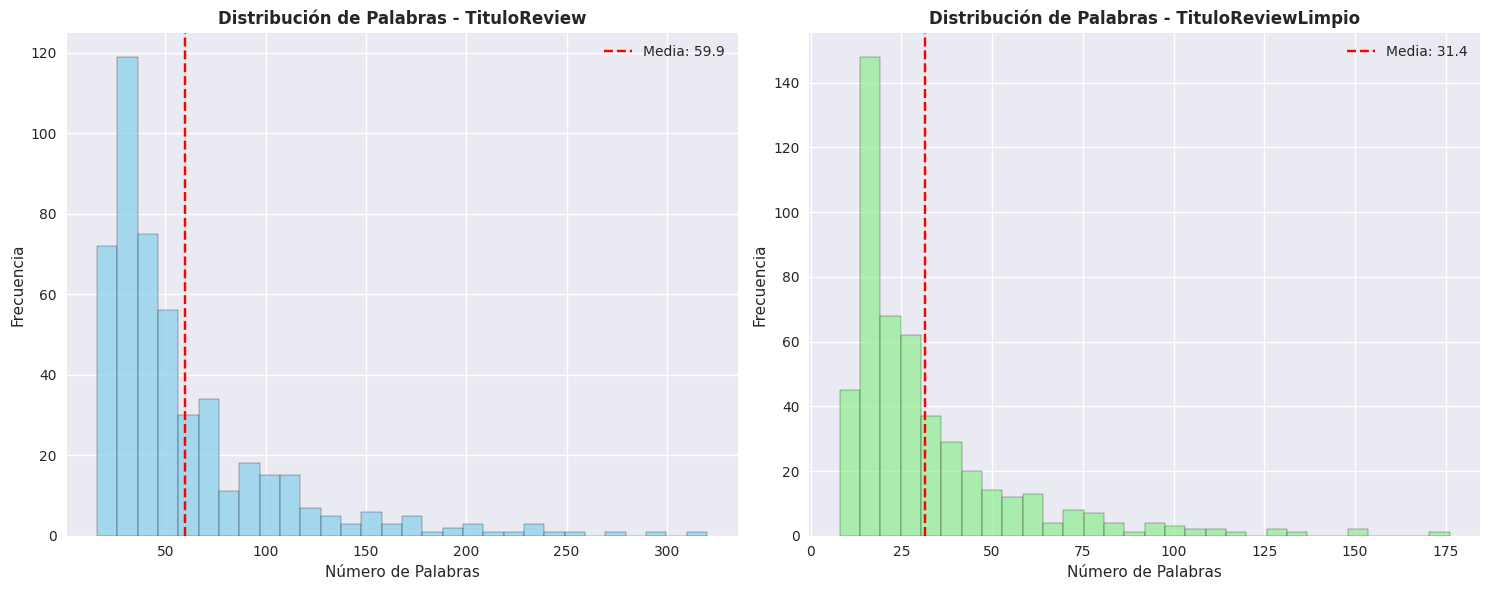

üìä ESTAD√çSTICAS DE DISTRIBUCI√ìN DE PALABRAS:
Original - Media: 59.9, Mediana: 43.0
Limpio   - Media: 31.4, Mediana: 23.0


In [26]:
# ===== COMPARACI√ìN TEXTO ORIGINAL VS TEXTO LIMPIO =====

if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"üîç Comparaci√≥n de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(15, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\nüìÑ EJEMPLO {i} - T√≥pico: {row['Topico_Nombre']}")
        print(f"üî∏ Original: {row['TituloReview']}")
        print(f"üîπ Limpio:   {row['TituloReviewLimpio']}")
        
        # Calcular estad√≠sticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        palabras_orig = len(str(row['TituloReview']).split())
        palabras_limpio = len(str(row['TituloReviewLimpio']).split())
        
        print(f"üìä Caracteres: {len_orig} ‚Üí {len_limpio} ({((len_orig-len_limpio)/len_orig*100):.1f}% reducci√≥n)")
        print(f"üìù Palabras: {palabras_orig} ‚Üí {palabras_limpio} ({((palabras_orig-palabras_limpio)/palabras_orig*100):.1f}% reducci√≥n)")
        print("-" * 80)
    
    # Estad√≠sticas generales de limpieza
    from topicos.utils_topicos import visualizar_distribucion_palabras, mostrar_estadisticas_limpieza
    
    print(f"\nüìà ESTAD√çSTICAS GENERALES DE LIMPIEZA - {CIUDAD_ANALIZAR}")
    mostrar_estadisticas_limpieza(df_con_topicos, 'TituloReview', 'TituloReviewLimpio')
    
    # Visualizaci√≥n de distribuci√≥n de palabras
    visualizar_distribucion_palabras(df_con_topicos, 'TituloReview', 'TituloReviewLimpio')

In [27]:
# ===== VISUALIZACIONES INTERACTIVAS DE BERTOPIC =====

print(f"Visualizaciones interactivas de BERTopic para {CIUDAD_ANALIZAR}:")
print(f"T√≥picos identificados: {len(topic_info)} (incluyendo outliers si los hay)")

# Validar si tenemos suficientes t√≥picos para visualizaciones
num_topicos_validos = len([t for t in topic_info['Topic'] if t != -1])
print(f"T√≥picos v√°lidos (sin outliers): {num_topicos_validos}")

if num_topicos_validos < 2:
    print("‚ö†Ô∏è ADVERTENCIA: Muy pocos t√≥picos identificados para generar visualizaciones interactivas.")
    print("üí° Esto puede deberse a:")
    print("   - Textos muy similares despu√©s de la limpieza")
    print("   - Dataset peque√±o para la ciudad seleccionada")
    print("   - Par√°metros de clustering muy restrictivos")
    print("\nüìä Mostrando informaci√≥n b√°sica de t√≥picos:")
    for topic_id in topic_info['Topic']:
        if topic_id != -1:
            topic_words = topic_model.get_topic(topic_id)
            print(f"\nT√≥pico {topic_id}: {topic_names.get(topic_id, 'Sin nombre')}")
            print(f"Palabras clave: {', '.join([word for word, _ in topic_words[:8]])}")
            print(f"Documentos: {topic_info[topic_info['Topic'] == topic_id]['Count'].iloc[0]}")
else:
    # Intentar generar visualizaciones con manejo de errores
    try:
        print("\nüó∫Ô∏è Generando mapa de t√≥picos...")
        fig_intertopic = topic_model.visualize_topics()
        fig_intertopic.update_layout(title=f"Mapa de T√≥picos - {CIUDAD_ANALIZAR}")
        fig_intertopic.show()
    except Exception as e:
        print(f"‚ùå Error al generar mapa de t√≥picos: {str(e)}")
        print("üí° Esto es normal con pocos t√≥picos o datos limitados")

    try:
        print("\nüìä Generando gr√°fico de barras...")
        fig_barchart = topic_model.visualize_barchart(top_n_topics=min(8, num_topicos_validos))
        fig_barchart.update_layout(title=f"Palabras Clave por T√≥pico - {CIUDAD_ANALIZAR}")
        fig_barchart.show()
    except Exception as e:
        print(f"‚ùå Error al generar gr√°fico de barras: {str(e)}")
        print("üîß Mostrando informaci√≥n alternativa de palabras clave:")
        for topic_id in topic_info['Topic'][:5]:  # Mostrar m√°ximo 5 t√≥picos
            if topic_id != -1:
                topic_words = topic_model.get_topic(topic_id)
                print(f"\nüìà {topic_names.get(topic_id, f'T√≥pico {topic_id}')}:")
                print(f"   {', '.join([f'{word}({score:.3f})' for word, score in topic_words[:5]])}")

    try:
        print("\nüå≥ Generando jerarqu√≠a de t√≥picos...")
        if num_topicos_validos >= 3:  # Necesitamos al menos 3 t√≥picos para jerarqu√≠a
            fig_hierarchy = topic_model.visualize_hierarchy()
            fig_hierarchy.update_layout(title=f"Jerarqu√≠a de T√≥picos - {CIUDAD_ANALIZAR}")
            fig_hierarchy.show()
        else:
            print("‚ö†Ô∏è Se necesitan al menos 3 t√≥picos para mostrar jerarqu√≠a")
    except Exception as e:
        print(f"‚ùå Error al generar jerarqu√≠a: {str(e)}")

# Informaci√≥n adicional sobre la calidad del modelado
print(f"\nüìã Resumen del modelado:")
print(f"‚úÖ Textos analizados: {len(texts)}")
print(f"üéØ T√≥picos encontrados: {num_topicos_validos}")
print(f"üìä Distribuci√≥n:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")

if num_topicos_validos <= 3:
    print(f"\nüí° Sugerencias para mejorar el modelado:")
    print(f"   - Reducir min_cluster_size en HDBSCAN (actualmente: {hdbscan_model.min_cluster_size})")
    print(f"   - Incluir m√°s ciudades en el an√°lisis")
    print(f"   - Ajustar par√°metros de limpieza de texto")
    print(f"   - Verificar diversidad en los textos de entrada")

Visualizaciones interactivas de BERTopic para Cdmx:
T√≥picos identificados: 11 (incluyendo outliers si los hay)
T√≥picos v√°lidos (sin outliers): 10

üó∫Ô∏è Generando mapa de t√≥picos...



üìä Generando gr√°fico de barras...



üå≥ Generando jerarqu√≠a de t√≥picos...



üìã Resumen del modelado:
‚úÖ Textos analizados: 490
üéØ T√≥picos encontrados: 10
üìä Distribuci√≥n:
   1. Experiencias en museos: 102 opiniones (20.8%)
   2. Cultura y Arte Mexicano: 80 opiniones (16.3%)
   3. Opiniones Diversas: 79 opiniones (16.1%)
   4. Experiencia religiosa y cultural: 42 opiniones (8.6%)
   5. Visitas a Z√≥calos Urbanos: 37 opiniones (7.6%)


In [ ]:
# Guardar dataset original con la nueva columna TopicoConBERTopic
print("üíæ Guardando dataset actualizado...")
df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

print("‚úÖ Dataset actualizado y guardado:")
print(f"üìÅ Archivo: ../data/processed/dataset_opiniones_analisis.csv")
print(f"üìä Total opiniones: {len(df)}")
print(f"üéØ Ciudad analizada: {CIUDAD_ANALIZAR}")
print(f"‚úÖ Opiniones con t√≥pico: {df['TopicoConBERTopic'].notna().sum()}")
print(f"‚è≥ Opiniones pendientes: {df['TopicoConBERTopic'].isna().sum()}")

print(f"\nüìà Estad√≠sticas de {CIUDAD_ANALIZAR}:")
print(f"T√≥picos identificados: {len(topico_counts)}")
print(f"Opiniones analizadas: {len(df_con_topicos)}")
print(f"Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")

# Informaci√≥n sobre limpieza de texto
if 'TituloReviewLimpio' in df.columns:
    print(f"\nüßπ Informaci√≥n de limpieza de texto:")
    print(f"üìù Columna de texto limpio: TituloReviewLimpio")
    print(f"üîß M√©todo utilizado: {columna_texto}")
    textos_limpios_total = df['TituloReviewLimpio'].notna().sum()
    print(f"‚úÖ Textos limpios disponibles: {textos_limpios_total}")
    
    if textos_limpios_total > 0:
        # Calcular estad√≠sticas de mejora
        palabras_promedio_limpio = df['TituloReviewLimpio'].dropna().str.split().str.len().mean()
        print(f"üìä Promedio palabras (texto limpio): {palabras_promedio_limpio:.1f}")

print(f"\nüîÑ Para analizar otra ciudad:")
print(f"1. Cambia la variable CIUDAD_ANALIZAR en la celda correspondiente")
print(f"2. Ejecuta nuevamente las celdas de an√°lisis")
print(f"üìç Ciudades disponibles: {list(df['Ciudad'].unique())}")
print(f"‚ö†Ô∏è IMPORTANTE: Los resultados previos se SOBRESCRIBEN autom√°ticamente")

print(f"\nüí° Mejoras implementadas:")
print(f"‚úÖ Limpieza profunda de texto con spaCy")
print(f"‚úÖ Lematizaci√≥n adecuada para espa√±ol")
print(f"‚úÖ Eliminaci√≥n de stopwords en espa√±ol e ingl√©s")
print(f"‚úÖ Eliminaci√≥n de emojis, URLs y caracteres especiales")
print(f"‚úÖ Nueva columna TituloReviewLimpio agregada al dataset")
print(f"‚úÖ Sobrescritura autom√°tica de resultados para ciudades repetidas")

‚úÖ Dataset actualizado:
üìÅ Archivo: ../data/processed/dataset_opiniones_analisis.csv
üìä Total opiniones: 2464
üéØ Ciudad analizada: Cdmx
‚úÖ Opiniones con t√≥pico: 973
‚è≥ Opiniones pendientes: 1491

üìà Estad√≠sticas de Cdmx:
T√≥picos identificados: 11
Opiniones analizadas: 490
Probabilidad promedio: 0.511

üßπ Informaci√≥n de limpieza de texto:
üìù Columna de texto limpio: TituloReviewLimpio
üîß M√©todo utilizado: TituloReviewLimpio
‚úÖ Textos limpios disponibles: 2464
üìä Promedio palabras (texto limpio): 30.4

üîÑ Para analizar otra ciudad:
1. Cambia la variable CIUDAD_ANALIZAR en la celda correspondiente
2. Ejecuta nuevamente las celdas de an√°lisis
üìç Ciudades disponibles: ['Cancun', 'Cdmx', 'Puebla', 'Mazatlan', 'Puerto_vallarta']

üí° Mejoras implementadas:
‚úÖ Limpieza profunda de texto con NLTK
‚úÖ Eliminaci√≥n de stopwords en espa√±ol e ingl√©s
‚úÖ Lematizaci√≥n y normalizaci√≥n
‚úÖ Eliminaci√≥n de emojis, URLs y caracteres especiales
‚úÖ Nueva columna TituloR